# Imports

In [ ]:
# import section
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt
from scipy import signal
import scipy
import os
import copy
import time
import cv2
from google.colab.patches import cv2_imshow
from skimage import data
from skimage import feature
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from google.colab import drive
from google.colab import files


!pip install scipy==1.6.2
!pip install opencv-python==3.4.2.17 opencv-contrib-python==3.4.2.17

# Mount Drive

In [ ]:
drive.mount("/content/drive", force_remount=True)
%ls
%cd '/content/drive/MyDrive/Colab Notebooks/V&P/assignment2_imageProcessing'
%ls

Mounted at /content/drive
drive/  sample_data/
/content/drive/MyDrive/Colab Notebooks/V&P/assignment2_imageProcessing
CV_assignment_ImageProcessing_2.pdf  exercise_13_no.ipynb
es10/                                instance_exercise1-7.ipynb
es11/                                plot1.png
es12/                                plot2.png
es13/                                plot.png
exercise_10.ipynb                    sample_image_fast.jpg
exercise_11.ipynb                    sample_image_harris.jpg
exercise_12.ipynb                    try1-7Exercise.ipynb
exercise_13.ipynb                    working_env_harris.jpg


# load data

In [ ]:
def readImage(path, show_it = False):
        img = cv2.imread(path)
        img = cv2.resize(img,(800,600)) # 4:3
        img_converted = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        # img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        if show_it:
            fig,ax = plt.subplots(figsize=(25, 10))
            ax.imshow(img_converted, cmap=plt.cm.gray)
        return img

def getFiles(train, path):
    images = []
    count = 0
    for folder in os.listdir(path):
        for file in  os.listdir(path +'/'+ folder):
            images.append(path+'/' + folder  + '/'+  file)

    if(train is True):
        np.random.shuffle(images)
    return images

working_env = readImage("./es11/working_env.jpg",False)

# Features extractors and SIFT descriptor

In [ ]:
def harrisDetection(img_color):

    # convert to gray-scale
    img = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
        # modify the data type
    # setting to 32-bit floating point
    img = np.float32(img)

    # get the corner distribution probability, thresholded corner response
    dst = cv2.cornerHarris(img,2,3,0.04)

    # it's possible to use dilation here (Results are marked through the dilated corners)
    # dst = cv2.dilate(dst,None)

    # Threshold for an optimal value, it may vary depending on the image.
    # Reverting back to the original image with optimal threshold value (non maximal suppresion)
    non_max_sup = dst> 0.1*dst.max() 
    img_color[non_max_sup]=[0,0,255] # mark with red dot 

    # creation of the keypoints
    keypoints = np.argwhere(non_max_sup)
    # list of keypoints objects or a numpy array
    kps = [cv2.KeyPoint(float(x[1]), float(x[0]), 1) for x in keypoints]
    corners = np.array([[float(x[1]), float(x[0])] for x in keypoints])

    return kps, corners

def get_descriptors_HCD(image, sift):
    kps, corners  = harrisDetection(image)
    _, des = sift.compute(image, kps)
    return des, kps

def get_corners_HCD(image):
    kps, corners  = harrisDetection(image)
    return corners, kps

def get_descriptors_FAST(image,descriptor):
    img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    fast = cv2.FastFeatureDetector_create()
    fast.setNonmaxSuppression(True)
    fast.setThreshold(50)
    kp = fast.detect(img,None)
    _, des = descriptor.compute(image,  kp)
    return des, kp

def get_descriptors_HCD_FAST(image,descriptor):
  _, kpHCD = get_descriptors_HCD(image, descriptor)
  _, kpFAST = get_descriptors_FAST(image, descriptor)
  kp = kpHCD + kpFAST
  kp , des = descriptor.compute(image, kp)
  return des, kp

def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 
    return descriptors

# 1) Extraction of features

In [ ]:
# create sift for descriptors
sift = cv2.xfeatures2d.SIFT_create()

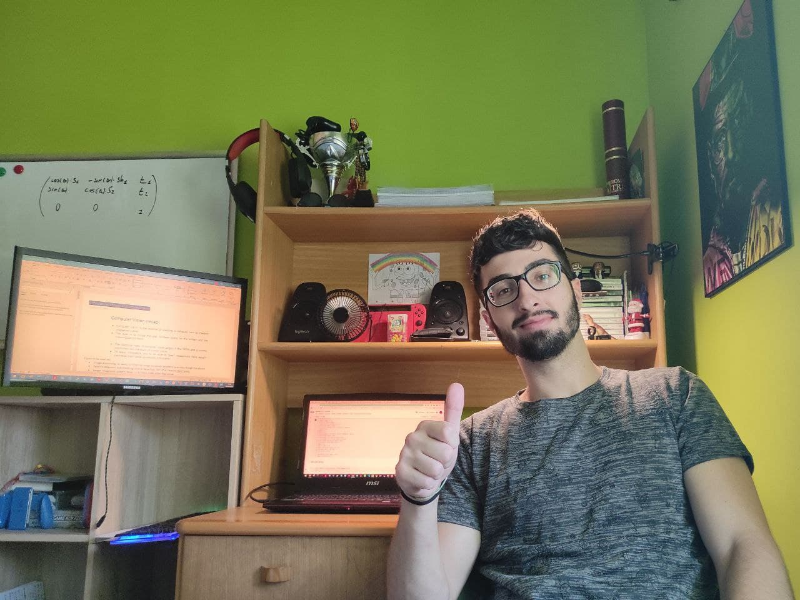

number of corners: 514


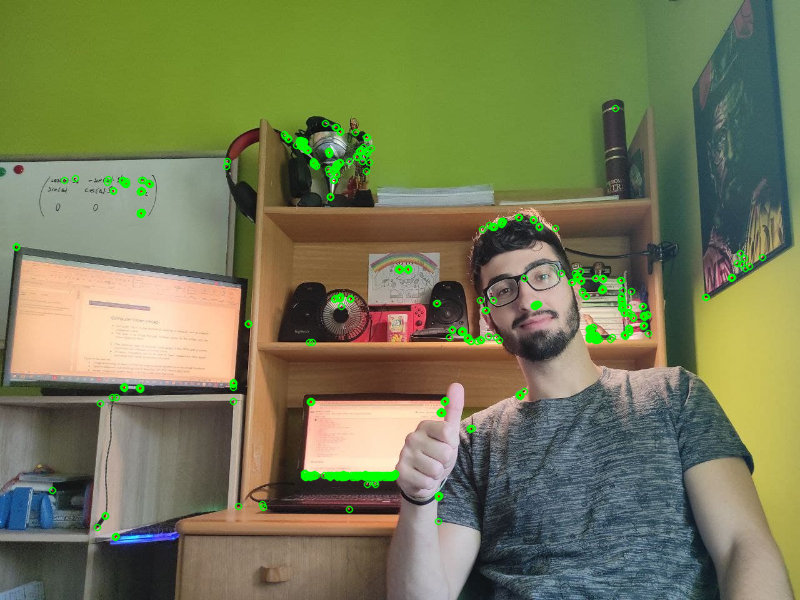

True

In [ ]:
# Harris corner detection
cv2_imshow(working_env)
img = copy.deepcopy(working_env)

# test - descriptors

des, kp = get_descriptors_HCD(img,sift)
print("number of corners: {}".format(len(kp)))

out_img = None
out_img= cv2.drawKeypoints(img,kp, outImage = out_img,color=(0,255,0))
cv2_imshow(out_img)
cv2.imwrite("working_env_harris.jpg", out_img)

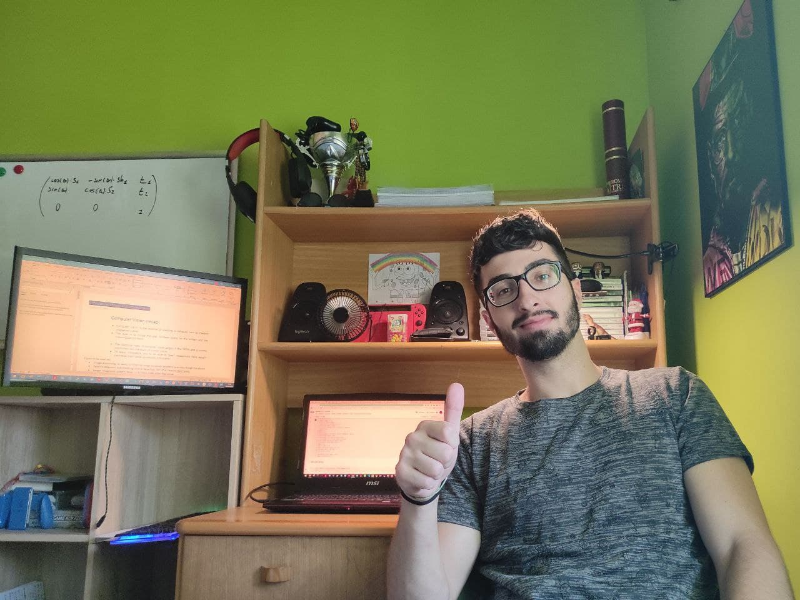

number of descriptors: 648


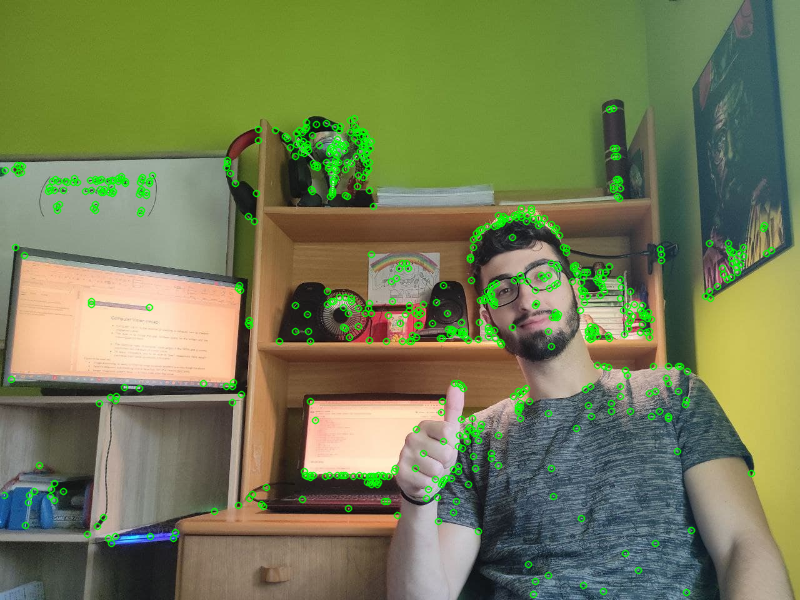

True

In [ ]:
# FAST features extracted

cv2_imshow(working_env)
img = copy.deepcopy(working_env)

# sift = cv2.xfeatures2d.SIFT_create()
des, kp = get_descriptors_FAST(img,sift)
print("number of descriptors: {}".format(len(des)))
out_img = None
out_img= cv2.drawKeypoints(img,kp, outImage = out_img,color=(0,255,0))
cv2_imshow(out_img)
cv2.imwrite("sample_image_fast.jpg", out_img)

# Evaluation functions

In [ ]:
def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plotConfusions(true, predictions, feature_extractor):
    np.set_printoptions(precision=2)

    class_names = ["dino", "racoon"]
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization (' + feature_extractor +')')

    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix (' + feature_extractor +')')

    plt.show()

def findAccuracy(true, predictions):
    print ('accuracy score: %0.3f' % accuracy_score(true, predictions))

# classification model

In [ ]:
def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
      features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)
    class_weight = {
        0: (807 / (7 * 140)),
        1: (807 / (7 * 140))
    }
  
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param, class_weight = class_weight)
    svm.fit(features, train_labels)
    return svm

# Bow functions

In [ ]:
def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

def extractFeatures(kmeans, descriptor_list, image_count, no_clusters, second_dim):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, second_dim)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

def normalizeFeatures(scale, features):
    return scale.transform(features)

def plotHistogram(im_features, no_clusters, feature_extractor):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])
    
    plt.figure(figsize=(15,7))
    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated (" + feature_extractor +")")
    plt.xticks(x_scalar + 0.4, x_scalar)

    plt.show()

# Training and Testing

In [ ]:
def trainModel(path, no_clusters, kernel, feature_extractor):
    images = getFiles(True, path)

    descriptorExtractor = cv2.xfeatures2d.SIFT_create()

    print("Train images path detected.")
    descriptor_list = []
    train_labels = np.array([])
    label_count =2
    image_count = len(images)
    startTime = time.time()

    for img_path in images:
        if ("dino" in img_path):
            class_index = 0
        elif("racoon" in img_path):     #racoon
            class_index = 1

        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)
        des = None

        if feature_extractor == 'Harris corner detector':
          des, _  = get_descriptors_HCD(img, descriptorExtractor)
        elif feature_extractor == 'FAST':
          des, _ = get_descriptors_FAST(img,descriptorExtractor)
        elif feature_extractor == 'HCD&FAST':
          des, _ = get_descriptors_HCD_FAST(img,descriptorExtractor)

        descriptor_list.append(des)
    
    print("End creation descriptors, time: {} [s], with {} elements".format((time.time() -startTime), len(descriptor_list)))
    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters, 128)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters, feature_extractor)
    print("Features histogram plotted.")

    print(train_labels)

    svm = findSVM(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features

def testModel(path, kmeans, scale, svm, im_features, no_clusters, kernel, feature_extractor):
    test_images = getFiles(False, path)
    print("Test images path detected.")

    count = 0
    true = []
    descriptor_list = []

    name_dict =	{
        "0": "dino",
        "1": "racoon",
    }

    descriptorExtractor = cv2.xfeatures2d.SIFT_create()
    
    for img_path in test_images:
        img = readImage(img_path)
        des = None

        if feature_extractor == "Harris corner detector":
           des, _  = get_descriptors_HCD(img, descriptorExtractor)
        elif feature_extractor == 'FAST':
          des, _ = get_descriptors_FAST(img,descriptorExtractor)
        elif feature_extractor == 'HCD&FAST':
          des, _ = get_descriptors_HCD_FAST(img,descriptorExtractor)

        if (des is not None):
            count += 1
            descriptor_list.append(des)

            if ("dino" in img_path):
                true.append("dino")
            else:
                true.append("racoon")

    descriptors = vstackDescriptors('descriptor_list')

    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters, 128)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print("Test images classified.")

    plotConfusions(true, predictions, feature_extractor)
    print("Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Accuracy calculated.")
    print("Execution done.")

# 2) Launching

Train images path detected.
End creation descriptors, time: 18.104592084884644 [s], with 60 elements
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


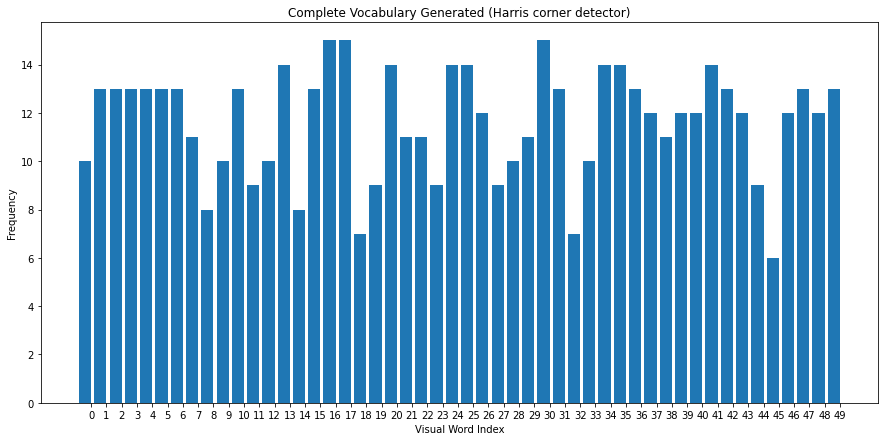

Features histogram plotted.
[1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1.
 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1.]
0.3 0.1
SVM fitted.
Training completed.
Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[17 13]
 [ 3 27]]
Normalized confusion matrix
[[0.57 0.43]
 [0.1  0.9 ]]


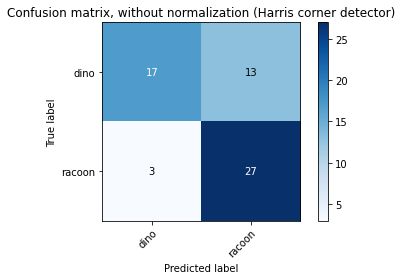

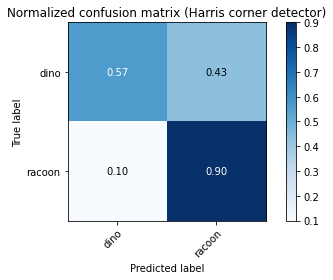

Confusion matrixes plotted.
accuracy score: 0.733
Accuracy calculated.
Execution done.


In [ ]:
# train and test model with HCD features

kmeans, scale, svm, im_features = trainModel("./es11/dataset/train", 50, 'linear', 'Harris corner detector')
testModel("./es11/dataset/test", kmeans, scale, svm, im_features, 50, 'linear', 'Harris corner detector')  

Train images path detected.
End creation descriptors, time: 6.434684753417969 [s], with 60 elements
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


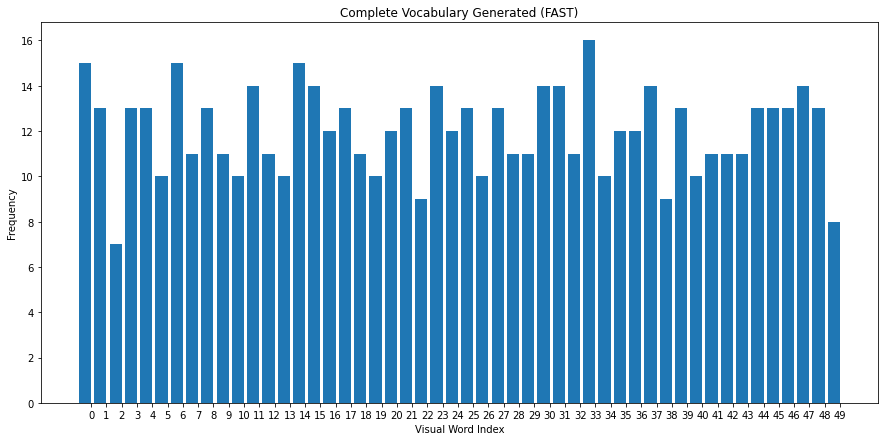

Features histogram plotted.
[1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0.]
0.5 0.1
SVM fitted.
Training completed.
Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[25  5]
 [ 0 30]]
Normalized confusion matrix
[[0.83 0.17]
 [0.   1.  ]]


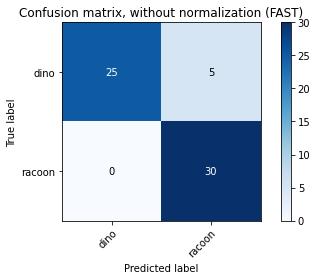

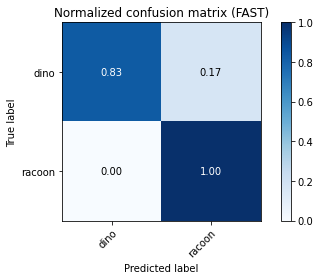

Confusion matrixes plotted.
accuracy score: 0.917
Accuracy calculated.
Execution done.


In [ ]:
# train and test model with FAST features

kmeans, scale, svm, im_features = trainModel("./es11/dataset/train", 50, 'linear', 'FAST')
testModel("./es11/dataset/train", kmeans, scale, svm, im_features, 50, 'linear', 'FAST')

Train images path detected.
End creation descriptors, time: 13.09963059425354 [s], with 60 elements
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


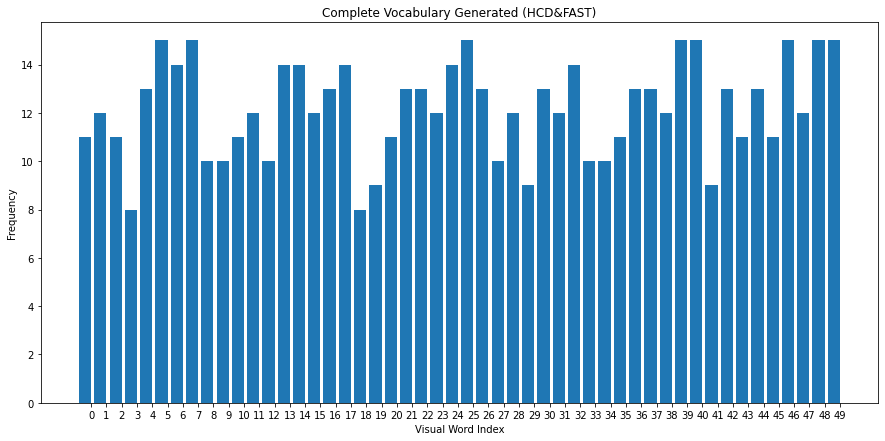

Features histogram plotted.
[0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
0.3 0.1
SVM fitted.
Training completed.
Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[27  3]
 [ 1 29]]
Normalized confusion matrix
[[0.9  0.1 ]
 [0.03 0.97]]


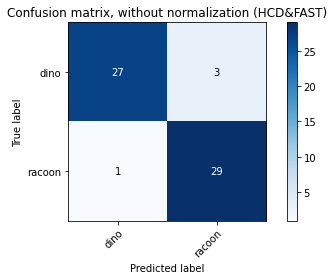

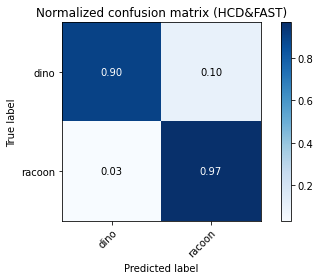

Confusion matrixes plotted.
accuracy score: 0.933
Accuracy calculated.
Execution done.


In [ ]:
# train and test model with HCD + FAST features

kmeans, scale, svm, im_features = trainModel("./es11/dataset/train", 50, 'linear', 'HCD&FAST')
testModel("./es11/dataset/train", kmeans, scale, svm, im_features, 50, 'linear', 'HCD&FAST')